In [2]:
import pandas as pd
from pandas import DataFrame
import keras as keras
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import csv

!pip install python_speech_features
from python_speech_features import mfcc

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=e140c9aa92cd6aebb7448be4d94243c94e1be5f9df8b9dae03e63273efd5265c
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [3]:
import glob
!git clone https://github.com/javierrca/eegcom.git
ds_path = "/content/eegcom/dataset"
person_code = "01"
base_path = ds_path + "/" + person_code
print('\nNamed with wildcard *:')
paths=[]
for name in glob.glob(base_path+'/*',recursive = True):
  paths.append(name+"/")

# print(paths)

!cd paths[0] && ls -l

Cloning into 'eegcom'...
remote: Enumerating objects: 1666, done.
remote: Counting objects: 100% (1666/1666), done.
remote: Compressing objects: 100% (1549/1549), done.
remote: Total 1666 (delta 87), reused 1658 (delta 82), pack-reused 0
Receiving objects: 100% (1666/1666), 14.12 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Filtering content: 100% (11/11), 1.40 GiB | 35.74 MiB/s, done.

Named with wildcard *:
/bin/bash: line 1: cd: paths[0]: No such file or directory


# Dataset CEP

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test,pred_y)
    plt.figure(figsize=(2,2))
    labels = ['0: No', '1: Si']
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    print(classification_report(y_test,pred_y))

def convert_to_mfccs(wav):
    # return mfcc(wav, 1, winstep=step, winlen=window, numcep=12)
    return mfcc(wav, 1, winstep=step, winlen=window, numcep=26)
     # return mfcc(wav, 1,winlen=25, winstep=1, numcep=26)



def getCepstral(paths):
    dfRaw = []
    X_raw_train = []
    y_raw_train =[]
    filter=[]
    filterLastRows = 1024

    i=0
    # print (paths)
    for path in paths:
        dfHead = pd.read_csv(path + 'head.csv')
        all_raw_files = glob.glob(os.path.join(path , "*RAW*.csv"))
        # print(dfHead[dfHead['questionCode']==24].iloc[0]['response'])

        for filename in all_raw_files:
            dfRaw = pd.read_csv(filename, index_col=None, header=0)
            if len(dfRaw)>filterLastRows:
                qCode = dfRaw['questionCode'].iloc[[0]][0]
                # print(qCode)
                X_raw_train.append([])
                X = np.array(dfRaw.tail(filterLastRows)['rawEeg'])
                # Pot MFCC spectrogram of input signal
                input_signal =X
                data = convert_to_mfccs(input_signal)
                X_raw_train[i] = data

                y_raw_train.append([])
                y_raw_train[i].append([])
                y_raw_train[i][0] = dfHead[dfHead['questionCode']==qCode].iloc[0]['response']
                i=i+1
    return X_raw_train,y_raw_train

window = 350
step = 100

X_raw_train = []
y_raw_train =[]
X_raw_train,y_raw_train= getCepstral(paths)
X = np.array(X_raw_train)
y = np.array(y_raw_train)
X.shape, y.shape


((225, 8, 26), (225, 1))

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2

y_val_cat =keras.utils.to_categorical(y_val,2)
y_train_cat =keras.utils.to_categorical(y_train,2)
y_test_cat =keras.utils.to_categorical(y_test,2)

X_train.shape, y_train.shape,X_test.shape,y_test.shape,X_val.shape, y_val.shape

((135, 8, 26), (135, 1), (45, 8, 26), (45, 1), (45, 8, 26), (45, 1))

# Modelo CEP/CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 25, 32)         160       
                                                                 
 batch_normalization (Batch  (None, 7, 25, 32)         128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 12, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 11, 64)         8256      
                                                                 
 batch_normalization_1 (Bat  (None, 2, 11, 64)         256       
 chNormalization)                                                
                                                        

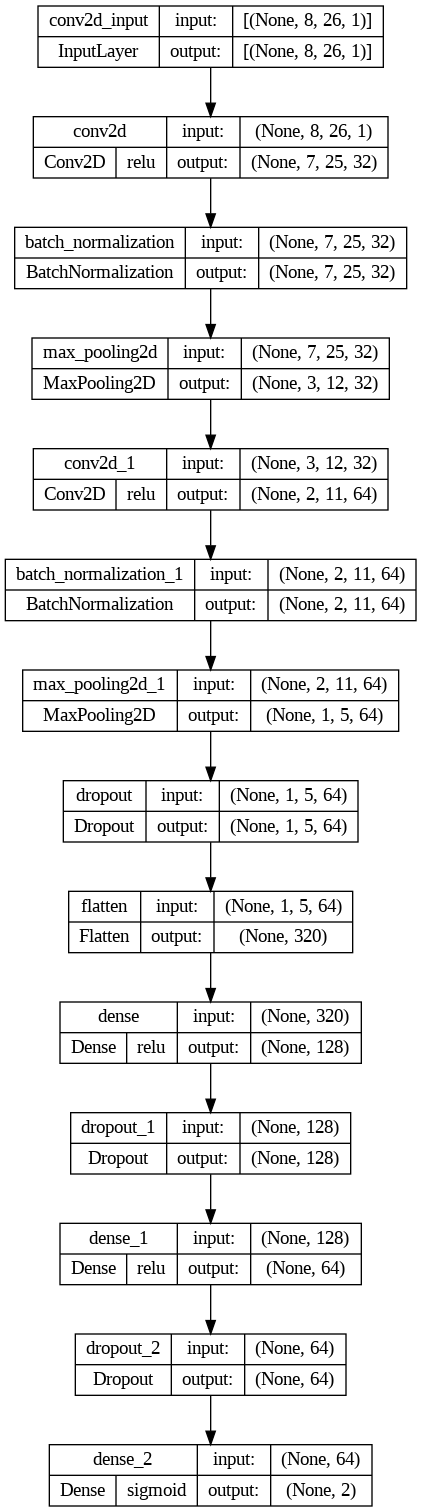

In [13]:
#model CEP/CNN
from keras.utils import plot_model
keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

input_shape=(X_train.shape[1],X_train.shape[2],1)

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(input_shape)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())

model.add(Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(2, activation="sigmoid"))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, 'net.png', show_shapes=True,show_layer_names=True,show_layer_activations=True)


In [ ]:

class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')> 0.6 and logs.get('accuracy')> 0.7 ):
        # if( logs.get('accuracy')> 0.87 ):

              print("\nAlcanzado el 85% de precisión, se cancela el entrenamiento!!")
              self.model.stop_training = True
callbacks2 =myCallback()


history = model.fit(X_train, y_train_cat, epochs=200, batch_size=16, validation_data=(X_val, y_val_cat), shuffle=True, callbacks=[callbacks2])

y_test_pred = model.predict(X_test)
y_test_pred2 = [np.argmax(i) for i in y_test_pred]
show_results(y_test,y_test_pred2)